### Libraries

In [1]:
import os
from PIL import Image
import time
import datetime
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import timm
import torch.nn.functional as F
import torchvision.transforms.v2 as v2
from torchvision.models import convnext_base
from collections import Counter
from torchvision.transforms import functional as TF
from scipy.ndimage import gaussian_filter, map_coordinates
from torch.optim.lr_scheduler import ReduceLROnPlateau
import kornia.augmentation as K
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
from torch.utils.data import random_split
import random
from torch.utils.data import DataLoader
import glob
from torchvision.transforms import ToPILImage
import torch
from torch.utils.data import Dataset
import segmentation_models_pytorch as smp
#!pip install git+https://github.com/facebookresearch/fvcore.git

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/shokoo/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pwd

'/home/shokoo/EchoView/view_classification/notebooks/models'

In [3]:
dataset_address = '/home/shokoo/EchoView/Datasets/data_split/'
files_address = '/home/shokoo/EchoView/view_classification'

In [4]:
paths = glob.glob(os.path.join(dataset_address + '**/*/*', '*')) #numebr of all samples per patients
len(paths)

665299

In [5]:
avg_data_mean = np.array([0.0847569 , 0.08113708, 0.08339239])
avg_data_std = np.array([0.17340048, 0.17009241, 0.17395345])

### Load the csv file containing the image file names and corresponding labels

In [6]:
info_train = pd.read_csv(os.path.join(files_address, 'csv_files/train_original.csv'))
info_val = pd.read_csv(os.path.join(files_address, 'csv_files/val_original.csv'))
info_test = pd.read_csv(os.path.join(files_address, 'csv_files/test_original.csv'))

In [7]:
len(info_train['label']), len(info_val['label']), len(info_test['label']), 

(4402, 1055, 1436)

In [76]:
print(Counter(info_train['label']))

Counter({'PLAX': 9740, 'Apical-4ch': 7710, 'Subcostal': 5860, 'PSAX-ves': 4810, 'Apical-2ch': 3700, 'Apical-3ch': 3660, 'Apical-5ch': 2150, 'PSAX-mid': 1970, 'PSAX-base': 1760, 'Suprasternal': 1470, 'PSAX-apical': 1190})


In [8]:
def visualize_normalized(image, label, mean, std):
    # Un-normalize
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image = image * std + mean  # reverse normalization

    # Convert to [0, 1] and clamp to avoid display issues
    image = torch.clamp(image, 0, 1)

    # Convert to HWC
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(image_np)
    plt.title(f"Label: {label.item()}")
    plt.axis('off')
    plt.show()


In [9]:
def visualization(image, label):
    plt.figure(figsize=(8, 6))
    
    if isinstance(image, torch.Tensor):
        if image.max() <= 1.0:
            image = image * 255.0  # Scale back to [0, 255] if needed
        image = image.byte().permute(1, 2, 0).cpu().numpy()
    
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Preprocessing

##### Define Transformers

In [10]:
class AddGaussianNoise(nn.Module):
    """Add Gaussian noise to a video."""
    def __init__(self, mean=0., std=0.1):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
class MotionBlurWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.blur = K.RandomMotionBlur(kernel_size=5, angle=[-10., 10.], direction=[-0.5, 0.5], p=1.0)

    def forward(self, x):
        return self.blur(x.unsqueeze(0)).squeeze(0)
    
class RandomErasingWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.coarse_dropout = K.RandomErasing(scale=(0.015, 0.04), ratio=(0.2, 3.3), p=0.2)

    def forward(self, x):
        return self.coarse_dropout(x.unsqueeze(0)).squeeze(0)

class QualityDecay(nn.Module):
    def __init__(self, strength=0.5, mode="noise_blur"):
        super().__init__()
        self.strength = strength
        self.mode = mode

    def forward(self, x):
        C, H, W = x.shape
        device = x.device

        # Create vertical + radial mask (0 at top/edge, 1 at bottom/center)
        y = torch.linspace(0, 1, H, device=device).unsqueeze(1).repeat(1, W)  # vertical gradient
        x_pos = torch.linspace(-1, 1, W, device=device).unsqueeze(0).repeat(H, 1)  # horizontal wedge
        r = torch.sqrt(x_pos**2 + (y - 0.5)**2)
        decay_mask = ((0.3 * y + 0.7 * r) ).clamp(0, 1)

        decay_mask = decay_mask.unsqueeze(0).repeat(C, 1, 1)  # [C, H, W]

        if self.mode == "noise_blur":
            noise = torch.randn_like(x) * decay_mask * self.strength
            x = x + noise
            # Apply slight blur by average pooling, weighted by mask
            blurred = F.avg_pool2d(x.unsqueeze(0), 3, stride=1, padding=1).squeeze(0)
            x = (1 - decay_mask) * x + decay_mask * blurred

        elif self.mode == "contrast_drop":
            mean = x.mean(dim=(1, 2), keepdim=True)
            x = (1 - decay_mask) * x + decay_mask * mean  # pull toward mean (less contrast)

        return x

In [11]:
original_size = (224, 224) 
train_transform = nn.Sequential(
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.RandomRotation(degrees=30),
    v2.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    AddGaussianNoise(0., 0.1),
    MotionBlurWrapper(),
    RandomErasingWrapper(),
    QualityDecay(strength=0.3, mode='contrast_drop'),
    transforms.CenterCrop(180), transforms.Resize(original_size),
)

In [12]:
def apply_augmentation(image, augmentation_list):
    """Applies a randomly selected augmentation from the list."""
    image = transforms.Grayscale(num_output_channels=3)(image)
    num_augmentations = len(augmentation_list)
    rand_list = list()
    i=2
    for _ in range(i):
        random_index = np.random.randint(num_augmentations)
        if random_index not in rand_list:
            rand_list.append(random_index)
        else:
            i+=1
        chosen_augmentation = augmentation_list[random_index]
        image = chosen_augmentation(image)
    
    return image

In [13]:
def view_specific_augmentation(image, augmentation_list):
    """Applies a randomly selected augmentation from the list."""
    image = transforms.Grayscale(num_output_channels=3)(image)
    num_augmentations = len(augmentation_list)
    rand_list = list()
    i=4
    for _ in range(i):
        random_index = np.random.randint(num_augmentations)
        if random_index not in rand_list:
            rand_list.append(random_index)
        else:
            i+=1
        chosen_augmentation = augmentation_list[random_index]
        image = chosen_augmentation(image)
    
    return image

### Map images to their labels

In [14]:
class TTEDataset(torch.utils.data.Dataset):
    def __init__(self, csv_info, root_dir, data_mean=0.5, data_std=0.5,
                 use_npy=True, transform=None, remove_ecg=True, remove_static=True):
        self.meta = csv_info
        self.root_dir = root_dir
        self.data_mean = data_mean
        self.data_std = data_std
        self.use_npy = use_npy
        self.transform = transform
        self.remove_ecg = remove_ecg
        self.remove_static = remove_static
        self.label_mapping = {
            'PLAX': 0, 'PSAX-ves': 1, 'PSAX-base': 2, 'PSAX-mid': 3,
            'PSAX-apical': 4, 'Apical-2ch': 5, 'Apical-3ch': 6,
            'Apical-5ch': 7, 'Apical-4ch': 8, 'Suprasternal': 9, 'Subcostal': 10
        }
        self.specific_views = ['PSAX-base', 'PSAX-mid','PSAX-apical','Apical-5ch','Subcostal']

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        path = row['path']
        case_path = path.split('/')[-1]
        # frame_id = row['frame']
        frame_id = 0
        label_key = row['label']
        label = torch.tensor([self.label_mapping[label_key]])
        frames = []

        # Load image
        if self.use_npy:
            npy_path = os.path.join(self.root_dir, path, "frames.npy")
            frames = np.load(npy_path)
            image = frames[frame_id]
        else:
            image_path = os.path.join(self.root_dir, path, f"{case_path}_{frame_id}.png")
            image = Image.open(image_path).convert("RGB")
            # image = self.ensure_tensor_rgb(image)

        # Remove ECG line
        if self.remove_ecg:
            image = self.remove_ecg_line(image)

        # Remove static background
        if self.remove_static:
            image = self.remove_static_background(image, path, frames, case_path, idx)

        # Tensor conversion
        image = self.ensure_tensor_rgb(image)

        # Transform
        if self.transform:
            image = apply_augmentation(image, self.transform)
        # elif self.transform and label_key in self.specific_views:
        #     image = view_specific_augmentation(image, self.transform)

        # Normalize
        image = TF.normalize(image, self.data_mean, self.data_std)
        image = TF.resize(image, size=(224,224))

        return image, label

    def ensure_tensor_rgb(self, image):
        if isinstance(image, np.ndarray):
            if image.max() > 1.0:
                image = image / 255.0
            image = torch.tensor(image).permute(2, 0, 1).float()
        elif isinstance(image, Image.Image):
            image = TF.to_tensor(image)
        elif isinstance(image, torch.Tensor):
            if image.max() > 1.0:
                image = image / 255.0
        return image

    def remove_ecg_line(self, image):
        if isinstance(image, Image.Image):
            image = np.array(image)
        hsv = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (40, 40, 40), (80, 255, 255))
        image[mask > 0] = 0
        return image

    def remove_static_background(self, image, path, frames=None, case_path='', index=0):
        if frames is None or len(frames) == 0:
            ref_frames = []
            for i in range(5):
                img_path = os.path.join(self.root_dir, path, f"{case_path}_{i}.png")
                if not os.path.exists(img_path):
                    print('path not found')
                    break
                img = TF.to_tensor(Image.open(img_path).convert("RGB"))
                ref_frames.append(img)
                
            frames = torch.stack(ref_frames).float() / 255.0
        else:
            frames = torch.tensor(frames).permute(0, 3, 1, 2).float() / 255.0

        if len(frames) < 2: # Not enough frames to compute mask
            print('not enught image')
            return image

        k = min(5, frames.shape[0])
        ref_mask = torch.zeros_like(frames[0], dtype=torch.uint8)
        for i in range(k - 1):
            ref_mask |= (frames[i] != frames[i + 1])

        image = self.ensure_tensor_rgb(image)
        return image * ref_mask


### Load the train,val,test dataset from the folder

In [15]:
train_data = TTEDataset(
    csv_info=info_train, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True, 
    transform=train_transform,
)

val_data = TTEDataset(
    csv_info=info_val, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True,
)

test_data = TTEDataset( 
    csv_info=info_test, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True 
)

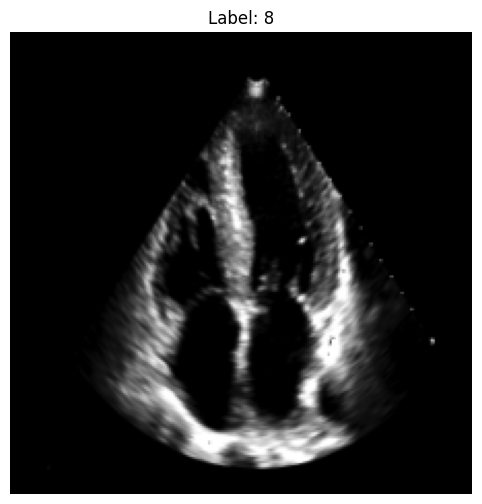

3463

In [16]:
num = random.randint(0,11000)
img, label = train_data[num]
visualize_normalized(img, label, avg_data_mean, avg_data_std)
num

### Create data loaders for the train and validation sets



In [17]:
train_loader = DataLoader(train_data, batch_size=32, drop_last=False, shuffle=True, pin_memory=True, num_workers= 1, persistent_workers=True)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=32, drop_last=False, shuffle=False, pin_memory=True, num_workers= 1, persistent_workers=True)
# collate_fn=collate_fn)
# #pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=32, drop_last=False, shuffle=False, pin_memory=True, num_workers= 1, persistent_workers=True)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [18]:
for i,l in train_loader:
    print(i.shape)
    break

torch.Size([32, 3, 224, 224])


### Define the neural network model architecture

In [151]:
combined_view_map = {
    0 : 'plax',          # PLAX
    1: 'psax-ves',     # PSAX-ves
    2: 'psax-sub',     # PSAX-base
    3: 'psax-sub',     # PSAX-mid
    4: 'psax-sub',     # PSAX-apical
    5: 'apical-2ch',   # Apical-2ch
    6: 'apical-3ch',   # Apical-3ch
    7: 'apical-4&5ch',   # Apical-5ch
    8: 'apical-4&5ch',   # Apical-4ch
    9: 'suprasternal',   # Suprasternal   
    10: 'subcostal'      # Subcostal
}

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared_MLP = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // reduction, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_MLP(self.avg_pool(x))
        max_out = self.shared_MLP(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, spatial_kernel=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(channels, reduction)
        self.sa = SpatialAttention(spatial_kernel)
        self.dropout2d = nn.Dropout2d(p=0.2)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        x = self.dropout2d(x)
        return x

class CNN_CBAM(nn.Module):
    def __init__(self, backbone_type='convnext_base', num_classes= 11):
        super(CNN_CBAM, self).__init__()

        self.group_names = ['plax', 'psax-ves', 'psax-sub', 'apical-2ch', 'apical-3ch', 'apical-4&5ch', 'suprasternal', 'subcostal']
        self.view_id_to_group_idx = {
            view_id: self.group_names.index(combined_view_map[view_id])
            for view_id in range(11)
        }

        if backbone_type.startswith('convnext'):
            base_model = getattr(torchvision.models, backbone_type)(weights='IMAGENET1K_V1')
            self.features = base_model.features
            feature_channels = 768 # small 768 # base 1024

        elif backbone_type.startswith('efficientnet-b2'):
            base_model = torchvision.models.efficientnet_b2(weights='DEFAULT')
            self.features = base_model.features
            feature_channels = 1408
            
        else:
            base_model = timm.create_model(backbone_type, pretrained=True, features_only=True) ## gets 224x224
            self.features = base_model
            feature_channels = base_model.feature_info[-1]['num_chs']

        self.dropout2d = nn.Dropout2d(p=0.2)

        self.cbam = CBAM(channels=feature_channels)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(feature_channels, num_classes)
        )

    def forward(self, x):
        if isinstance(self.features, nn.Sequential ):
            x = self.features(x)
        else:
            x = self.features(x)[-1]

        x = self.dropout2d(x)
        # x = self.cbam(x)
        x = self.classifier(x)
        return x
    
backbone_type = 'convnext_small'
num_classes = 8
model = CNN_CBAM(backbone_type=backbone_type, num_classes=num_classes) #Convnext_FC (model name without CBAM)

In [19]:
combined_view_map = {
    0 : 'plax',          # PLAX
    1: 'psax-ves',     # PSAX-ves
    2: 'psax-sub',     # PSAX-base
    3: 'psax-sub',     # PSAX-mid
    4: 'psax-sub',     # PSAX-apical
    5: 'apical-2ch',   # Apical-2ch
    6: 'apical-3ch',   # Apical-3ch
    7: 'apical-4&5ch',   # Apical-5ch
    8: 'apical-4&5ch',   # Apical-4ch
    9: 'suprasternal',   # Suprasternal   
    10: 'subcostal'      # Subcostal
}

view_to_group = {
    0: 'other',    # PLAX
    1: 'other',    # PSAX-ves
    2: 'psax',     # PSAX-sub
    3: 'apical',   # Apical-2ch
    4: 'apical',   # Apical-3ch
    5: 'apical',   # Apical-4&5ch
    6: 'other',   # Suprasternal
    7: 'other',    # Subcostal
}

group_to_labels = {
    'apical': [3,4,5],
    'psax': [2],
    'other': [0,1,6,7],
}

# ----------- Router Model -------------- #
class Router(nn.Module):
    def __init__(self, feature_dim, num_groups = 3):
        super().__init__()
        self.classifier = nn.Linear(feature_dim, num_groups)
        self.group_names2 = ['apical', 'psax', 'other']

    def forward(self, features):
        return self.classifier(features) #[B, 4]


# ------------ Multi-Head Classifier ------------ #
class MultiHeadClassifier(nn.Module):
    def __init__(self, feature_dim, group_to_labels):
        super().__init__()
        self.group_to_labels = group_to_labels
        self.heads = nn.ModuleDict()
        for group, labels in group_to_labels.items():
            self.heads[group] = nn.Linear(feature_dim, len(labels))
        self.group_names = list(group_to_labels.keys())

    def forward(self, features, group_probs):
        logits = torch.zeros(features.size(0), max(max(v) for v in group_to_labels.values()) + 1).to(features.device)
        for i, group in enumerate(self.group_names):
            head = self.heads[group]
            group_logits = head(features)
            mapped_labels = self.group_to_labels[group]
            probs = group_probs[:, i].unsqueeze(1)  # (B, 1)
            for j, view_id in enumerate(mapped_labels):
                logits[:, view_id] += probs.squeeze() * group_logits[:, j]
        return logits


# ------------ Full Model ------------ #
class MultiViewClassifier(nn.Module):
    def __init__(self, backbone_type='convnext_small'):
        super().__init__()
        base = getattr(torchvision.models, backbone_type)(weights='IMAGENET1K_V1')
        self.features = nn.Sequential(base.features, nn.AdaptiveAvgPool2d((1, 1)))
        self.flatten = nn.Flatten()
        self.router = Router(768)
        self.multihead = MultiHeadClassifier(feature_dim=768, group_to_labels=group_to_labels)
        self.view_id_to_group_idx2 = {
            view_id: self.router.group_names2.index(view_to_group[view_id])
            for view_id in range(8)
        }
        self.group_names = ['plax', 'psax-ves', 'psax-sub', 'apical-2ch', 'apical-3ch', 'apical-4&5ch', 'suprasternal', 'subcostal']
        self.view_id_to_group_idx = {
            view_id: self.group_names.index(combined_view_map[view_id])
            for view_id in range(11)
        }


    def forward(self, x, labels=None):
        x = self.features(x)  # (B, 768, 1, 1)
        x = self.flatten(x)   # (B, 768)
        group_logits = self.router(x)
        group_probs = torch.softmax(group_logits, dim=1)
        view_logits = self.multihead(x, group_probs)
        return view_logits, group_logits
    
backbone_type = 'convnext_small'
model = MultiViewClassifier(backbone_type=backbone_type)

In [156]:
input1 = torch.rand(8, 3, 256, 256)
# input2 = torch.rand(8, 10, 3, 299, 299)
# model.eval()
print(model(input1))

(tensor([[ 0.0230, -0.0016,  0.0117, -0.0074, -0.0847, -0.0282,  0.0074, -0.0078],
        [ 0.0185,  0.0094, -0.0241,  0.0012, -0.1013, -0.0276,  0.0132, -0.0260],
        [ 0.0281,  0.0144, -0.0042,  0.0086, -0.0926, -0.0369,  0.0140, -0.0174],
        [ 0.0313,  0.0117, -0.0053,  0.0011, -0.0667,  0.0098,  0.0150, -0.0242],
        [ 0.0325,  0.0070,  0.0276, -0.0188, -0.0440, -0.0100,  0.0023, -0.0094],
        [ 0.0256,  0.0102, -0.0171,  0.0092, -0.1059, -0.0140,  0.0095, -0.0175],
        [ 0.0146,  0.0084,  0.0075, -0.0078, -0.0397, -0.0387, -0.0094,  0.0192],
        [ 0.0434,  0.0275, -0.0179, -0.0100, -0.0797,  0.0073,  0.0136, -0.0229]],
       grad_fn=<CopySlices>), tensor([[ 0.2572,  0.2761, -0.2091],
        [ 0.3914,  0.2057, -0.2365],
        [ 0.3478,  0.2237, -0.2307],
        [ 0.3061,  0.1827, -0.2008],
        [ 0.2385,  0.1665, -0.1268],
        [ 0.3384,  0.2846, -0.2544],
        [ 0.1090,  0.1814, -0.1012],
        [ 0.3509,  0.1858, -0.2034]], grad_fn=<AddmmB

### Freeze initial layers of the model

In [154]:
def freeze_backbone(model):
    for param in model.features.parameters():
        param.requires_grad = False

In [23]:
def unfreeze_backbone(model):
    for param in model.features.parameters():
        param.requires_grad = True

### Define loss and optimizer

In [ ]:
class PenalizedCrossEntropyLoss(nn.Module):
    def __init__(self, num_classes, penalty_map=None, base_loss_weight=1.0):
        super().__init__()
        self.base_loss_weight = base_loss_weight
        self.penalty_map = penalty_map or {}
        self.ce = nn.CrossEntropyLoss(reduction='none')  # compute per-sample loss

    def forward(self, logits, targets):
        preds = torch.argmax(logits, dim=1)
        base_losses = self.ce(logits, targets)

        # Apply penalties for specific (true_label, pred_label) combinations
        penalties = torch.ones_like(base_losses) * self.base_loss_weight

        for i in range(len(targets)):
            true_label = targets[i].item()
            pred_label = preds[i].item()
            if (true_label, pred_label) in self.penalty_map:
                penalties[i] *= self.penalty_map[(true_label, pred_label)]

        penalized_loss = base_losses * penalties
        return penalized_loss.mean()

penalty_map = {
    (5, 3): 3.0,   # true: 5 (Apical-2ch), predicted as 8 (Apical-4ch) → very bad
    (5, 4): 2.0,   # true: 5, predicted as 7 → bad
    (3, 4): 
    (3, 5): 4.0,
    (4, 5): 3.0
}

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion_nomral = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = PenalizedCrossEntropyLoss(num_classes=8, penalty_map=penalty_map)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# , weight_decay=1e-5) ## changed from 0.001 to 0.0001 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def update_optimizer(model, new_lr):
    return torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=new_lr, weight_decay=1e-5)

print(device)

cuda


### Train the model

In [29]:
def evaluate(model, loader, device, epoch, mode='validation'):
  model.eval()
  running_loss = 0.
  running_corrects_view = 0
  running_corrects_group = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      view_logits, group_logits = model(images)
      new_labels = torch.tensor([model.view_id_to_group_idx[v.item()] for v in labels], device=device)
      group_targets = torch.tensor([model.view_id_to_group_idx2[v.item()] for v in new_labels], device=device)
      group_loss = criterion_nomral(group_logits, group_targets)
      view_loss = criterion(view_logits, new_labels)
      loss = view_loss
      total += images.size(0)
      _, predictions_view = view_logits.max(1)
    _, predictions_group = group_logits.max(1)
    running_loss += loss.item() * images.size(0)
    running_corrects_view += (predictions_view == new_labels).sum()
    running_corrects_group += (predictions_group == group_targets).sum()

  epoch_loss = running_loss / total
  epoch_acc_group = running_corrects_group / total
  epoch_acc_view = running_corrects_view / total
  print(f'{mode} epoch {epoch}:  Loss({epoch_loss:6.4f}, Accuracy Group ({epoch_acc_group:6.5f}), Accuracy View ({epoch_acc_view:6.5f}) )')
  return epoch_acc_group, epoch_acc_view, loss


In [30]:
epochs = 10
backbone_freeze_epoch = 5
best_acc = 0
val_loss = 0.0
best_val_loss = float('inf')
best_model = None

# freeze_backbone(model)
# print("Backbone frozen.")

for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects_view = 0
  running_corrects_group = 0

  # if epoch == backbone_freeze_epoch:
  #   unfreeze_backbone(model)
  #   update_optimizer(model, new_lr=1e-5)
  #   print("Backbone unfrozen, optimizer updated.")

  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    view_logits, group_logits = model(images)
    labels = labels.squeeze(1)
    new_labels = torch.tensor([model.view_id_to_group_idx[v.item()] for v in labels], device=device)
    group_targets = torch.tensor([model.view_id_to_group_idx2[v.item()] for v in new_labels], device=device)
    group_loss = criterion_nomral(group_logits, group_targets)
    view_loss = criterion(view_logits, new_labels)
    loss = view_loss
    loss.backward()
    optimizer.step()

    total += images.size(0)
    _, predictions_view = view_logits.max(1)
    _, predictions_group = group_logits.max(1)
    running_loss += loss.item() * images.size(0)
    running_corrects_view += (predictions_view == new_labels).sum()
    running_corrects_group += (predictions_group == group_targets).sum()

  epoch_loss = running_loss / total
  epoch_acc_group = running_corrects_group / total
  epoch_acc_view = running_corrects_view / total

  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy Group ({epoch_acc_group:6.5f}), Accuracy View ({epoch_acc_view:6.5f}) )')
  val_acc_group, val_acc_view, val_loss = evaluate(model, val_loader, device, epoch, mode='valid')

  print('---')

  if(val_loss < best_val_loss):
    best_acc = val_acc_view
    best_val_loss = val_loss
    epochs_no_improve = 0
    best_model = copy.deepcopy(model)
#     torch.save(model.state_dict(), (f'/home/student/shokoofa/Downloads/res_model{epoch}.pth'))
  else:
    epochs_no_improve += 1

  if epochs_no_improve >= 2 and epoch >= 4 :
    print('no further improvement ', best_acc)
    break


Train epoch 0: Loss(1.9405, Accuracy Group (0.48501), Accuracy View (0.45434) )
valid epoch 0:  Loss(1.3719, Accuracy Group (0.59716), Accuracy View (0.55166) )
---
Train epoch 1: Loss(0.9335, Accuracy Group (0.74398), Accuracy View (0.72285) )
valid epoch 1:  Loss(0.8454, Accuracy Group (0.74028), Accuracy View (0.73365) )
---
Train epoch 2: Loss(0.6374, Accuracy Group (0.83553), Accuracy View (0.80282) )
valid epoch 2:  Loss(0.7163, Accuracy Group (0.87393), Accuracy View (0.80284) )
---
Train epoch 3: Loss(0.5508, Accuracy Group (0.90709), Accuracy View (0.86483) )
valid epoch 3:  Loss(0.7008, Accuracy Group (0.91848), Accuracy View (0.83128) )
---
Train epoch 4: Loss(0.4371, Accuracy Group (0.95888), Accuracy View (0.88846) )
valid epoch 4:  Loss(0.5076, Accuracy Group (0.95261), Accuracy View (0.87867) )
---
Train epoch 5: Loss(0.3154, Accuracy Group (0.96979), Accuracy View (0.92026) )
valid epoch 5:  Loss(0.5322, Accuracy Group (0.95735), Accuracy View (0.88057) )
---
Train epoc

In [41]:
# int('sd') + 3

In [ ]:
torch.save({
    'model_name': 'f{model.__class__.__name__}',
    'num_classes': f'{num_classes}',
    'discription': f'usig original csv files (1 frame per video), with a weighted loss model to penalize misclassifying 2 and 3, and 4&5 chambers , and a pretrained convnext model ({model.__class__.__name__}) combining views first with psax, plax and other group then with {num_classes} classes, trained with {backbone_type} backbone, two-stage classification model, including {[i.__class__.__name__ for i in train_transform]} in augmentation, images shape is {img.shape}',
    'accuracyOnVal' : round(val_acc_view.item(),3),
    'date': str(datetime.datetime.now()).split('.')[0],
    'state_dict': model.state_dict(),
    'model' : model,
}, os.path.join(files_address, 'notebooks/saved_models', f'model_{model.__class__.__name__}-bb_({backbone_type})-nclasses_{num_classes}-acc_{round(val_acc_view.item(),3)}-penalized-loss.pth'))

In [34]:
model = best_model if best_model != None else model

#### Load a Pretrained Model

In [ ]:
loaded_info = torch.load(os.path.join(files_address, 'notebooks/saved_models', 'model_EncoderViewClassifier-bb_(custom_efficientNet)-acc_0.633.pth'))
model = loaded_info['model']
description = loaded_info['discription']
description

# state_dict = torch.load('/home/shokoo/EchoView/video_class/singleframe/test3.pth', map_location='cpu')
# new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
# model.load_state_dict(new_state_dict)
# model.to(device)
# val_acc, val_loss = evaluate(model, val_loader, device, mode='valid')

"usig customized encoder model training from scratch, trained with custom_efficientNet backbone, two-stage classification model, including ['RandomHorizontalFlip', 'RandomVerticalFlip', 'RandomApply', 'RandomApply', 'RandomApply', 'RandomApply', 'RandomApply', 'RandomApply', 'RandomApply', 'RandomApply', 'RandomApply'] in augmentation, images shape is torch.Size([3, 224, 224])"

In [35]:
def evaluate_test(model, loader, device, mode='Test'):
  model.eval()
  total_correct = 0
  total_loss = 0
  indices = []
  predicted_labels = []
  true_labels = []
  confidences = []
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs, _ = model(images)
      # loss = criterion(outputs, labels)
      # total_loss += loss.item() * images.size(0)
      batch_start = i * loader.batch_size
      batch_indices = list(range(batch_start, batch_start + images.size(0)))
      total += images.size(0) 
      _, predictions = outputs.max(1)
      new_labels = torch.tensor([model.view_id_to_group_idx[v.item()] for v in labels], device=device)
      total_correct += (new_labels == predictions).sum()
      confidence = torch.softmax(outputs, dim=1)
      confidences.extend(confidence.cpu().numpy())
      indices.extend(batch_indices)
      predicted_labels.extend(predictions.cpu().numpy())
      true_labels.extend(new_labels.cpu().numpy())

  # print(total_correct, total, accuracy)
  # loss = total_loss / total
  accuracy = total_correct / total
  # print(f'{mode} Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  print(f'{mode}  Accuracy ({accuracy:6.4f}))')
  test_dict = {'indices': indices, 'predicted': predicted_labels, 'true_labels': true_labels, 'confidence': confidences }
  return accuracy, pd.DataFrame(test_dict)

_, test_dict = evaluate_test(model, loader= test_loader, device = device)

Test  Accuracy (0.8962))


In [36]:
true_labels, pred_labels = test_dict['true_labels'], test_dict['predicted']  

test = pd.concat([test_dict, info_test], axis = 1)

def get_mode(series):
    return series.mode()[0] if not series.mode().empty else None

def get_mean(series):
    return series.mean()

res = test.groupby(['path', 'true_labels', 'label']).agg({ 'confidence': get_mean, 'predicted': get_mode} ).reset_index() 
res['predicted2'] = res['confidence'].apply(lambda x : x.argmax())
res

def calculate_accuracy(true_labels, predicted_labels):
    correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    print(correct)
    total = len(true_labels)
    print(total, total - correct)
    accuracy = correct / total
    return accuracy

true_labels, pred_labels = res['true_labels'], res['predicted']
calculate_accuracy(true_labels, pred_labels)

1287
1436 149


0.8962395543175488

In [37]:
res[res['predicted']!=res['true_labels']]

,path,true_labels,label,confidence,predicted,predicted2
3,test/-8UKHE9bQ0u09nleXrwgBg/14,0,PLAX,"[0.17371327, 0.012412825, 0.04789079, 0.158927...",4,4
32,test/-8UKHE9bQ0u09nleXrwgBg/54,4,Apical-3ch,"[0.0013528774, 0.001202763, 0.0013053834, 0.93...",3,3
33,test/-8UKHE9bQ0u09nleXrwgBg/55,4,Apical-3ch,"[0.977879, 0.0009555252, 0.004504154, 0.004854...",0,0
36,test/-8UKHE9bQ0u09nleXrwgBg/60,4,Apical-3ch,"[0.7852614, 0.004036632, 0.028809499, 0.046263...",0,0
47,test/-HQr6nOJRs6eFWVbflK-Mw/14,0,PLAX,"[0.007716836, 0.0059182807, 0.009098202, 0.074...",5,5
...,...,...,...,...,...,...
1326,test/sGh0GBWUS5eOFQ0FDr0OhQ/80,7,Subcostal,"[0.99991, 2.7278671e-05, 1.02186e-05, 9.431645...",0,0
1348,test/sGsEiOtOT7KpgvkpsLWgtg/25,1,PSAX-ves,"[0.029878909, 0.14969805, 0.7322897, 0.0073093...",2,2
1394,test/sGsEiOtOT7KpgvkpsLWgtg/84,6,Suprasternal,"[0.07118083, 0.032704227, 0.06969602, 0.063732...",7,7
1431,test/zuM6a0WfQqWap1nEjaGmdQ/55,7,Subcostal,"[0.00066665007, 0.0012733539, 0.0007095089, 0....",6,6


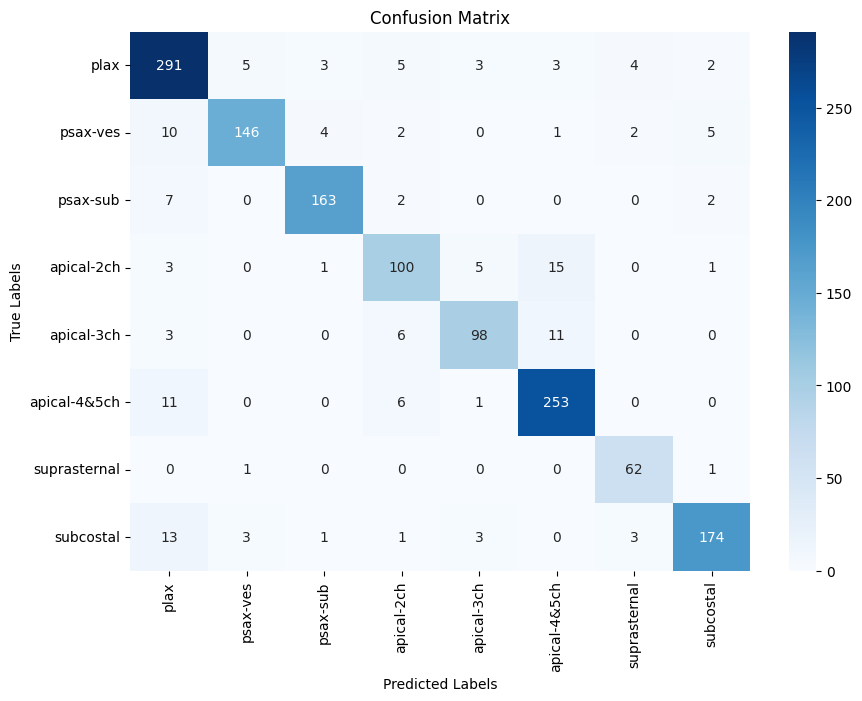

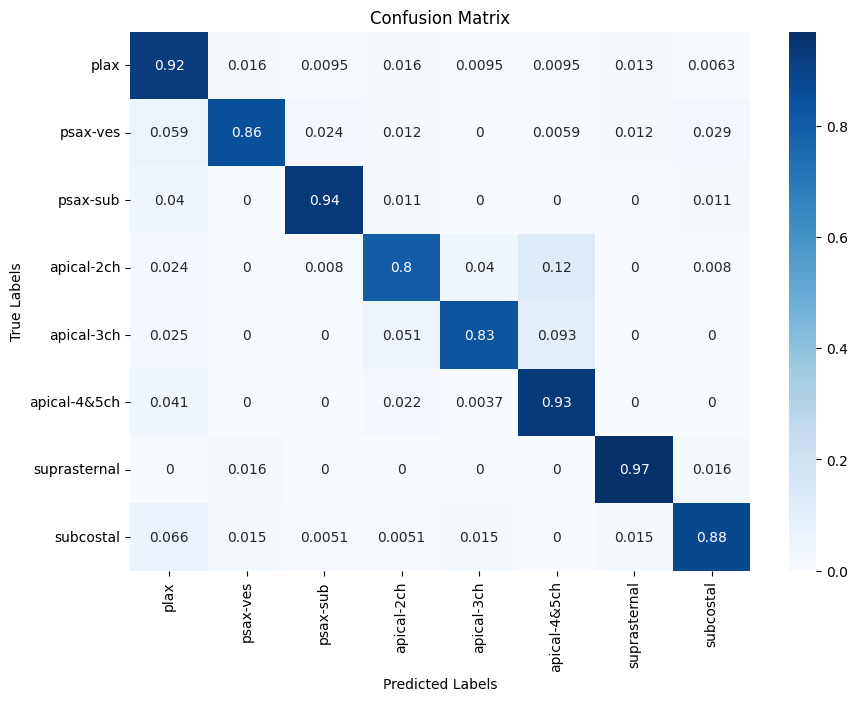

In [38]:
valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = ['plax', 'psax-ves', 'psax-sub', 'apical-2ch', 'apical-3ch', 'apical-4&5ch', 'suprasternal', 'subcostal']

# labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()